# Example Integer Programming Solver with OR Tools

A hello world intro to mixed integer programming with or-tools.

Recall our workflow:

1. Import linear solver wrapper
2. Declare the LP solver (i.e. `MPsolver`, `GLOP`)
3. Create Variables (i.e. `solver.NumVar(lb, ub, name)`)
4. Add Constraints `solver.Add`
5. Define Objective `solver.Maximize()`
6. Invoke the solver `solver.Solve()`
7. Display the solution

First, the preamble:

In [1]:
# 1. Import solver wrapper
from ortools.linear_solver import pywraplp

## Scenario

Let's imagine that we are a party of 4 adventurers and want to equip ourselves with weapons that do the most damage if we only have 20 coins in our budget. We come to a shopkeeper that sells bows, axes, spears, and swords but only has a limited number of each weapon. Which weapons should we buy to maximize our damage output while staying under our 20 coin budget?

In [2]:
# Here's our imaginary dataset:
names = ['bow', 'axe', 'spear', 'sword']

data = {}
data['damage'] = [6., 12., 6., 10.]     # Damage for each item
data['cost'] = [5., 9., 4., 10.]        # Prices for each item
data['inventory'] = [2, 1, 3, 1]        # Shopkeeper inventory

# 2. Declare solver
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver("SCIP")

We essentially just have 4 decision variables that are the number of weapon that we want to buy.

In [3]:
# Array to hold our variables
weapons = [solver.IntVar(0.0, solver.infinity(), name) for name in names]

print("Number of Variables: ", solver.NumVariables())

Number of Variables:  4


In [4]:
#Constraints

cost_limit = 20
# 0 <= 5a + 12b + 6c + 4d <= cost_limit
constraint = solver.RowConstraint(0, cost_limit, "Cost Constraint")  # Sum of the coefficients must be less than or equal to the ub
for i in range(4):
    constraint.SetCoefficient(weapons[i], data['cost'][i])

# Can also state it as:
# constraint_expr = [data['weight'][i] * weapons[i] for i in range(4)]
# solver.Add(sum(constraint_expr) <= weight_limit)

# Inventory Level Constraint
for i in range(4):
    solver.Add(weapons[i] <= data['inventory'][i])

# Need at least 4 weapons
solver.Add(sum(weapons) >= 4)

print("Number of Constraints: ", solver.NumConstraints())

# Objective
objective = solver.Objective()
for j in range(4):
    objective.SetCoefficient(weapons[j], data['damage'][j])
objective.SetMaximization()


Number of Constraints:  6


In [5]:
# Invoke solver
print(f"Solving with {solver.SolverVersion()}")
status = solver.Solve()

print("Optimal Damage: ", solver.Objective().Value())
for j in range(len(data['damage'])):
    print(weapons[j], weapons[j].solution_value())

Solving with SCIP 8.0.4 [LP solver: Glop 9.8]
Optimal Damage:  24.000000000000004
bow 1.0
axe 0.0
spear 3.0
sword 0.0


# Promo Calendar Optimization

We have 12 months, which months should we promote and what price should we sell at?

In [6]:
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

# Constants
elasticity = -1.4
baseline_price = 10
# baseline_price = 11.46
cost = 2
baseline_sales = 20
month_nums = range(12)

# Simulate Seasonality 
np.random.seed(99)

# Seasonality factors
seasonality = [np.random.uniform(1.25, 2.5) if m >= 4 and m <= 7 else
               np.random.uniform(0.5, 0.9) for m in month_nums]

px.line(seasonality, title='Seasonality', template='simple_white')

We can use the estimated price elasticity of demand to find the price that will optimize revenue. 

Imagine we used a log-log regression model to get the coefficients. Then if elasticity is $-1.5$, then a 10% decrease in price multiplies the demand by $e^{-1.5 * \log(0.9)} = 1.17$ or a 17% increase in demand

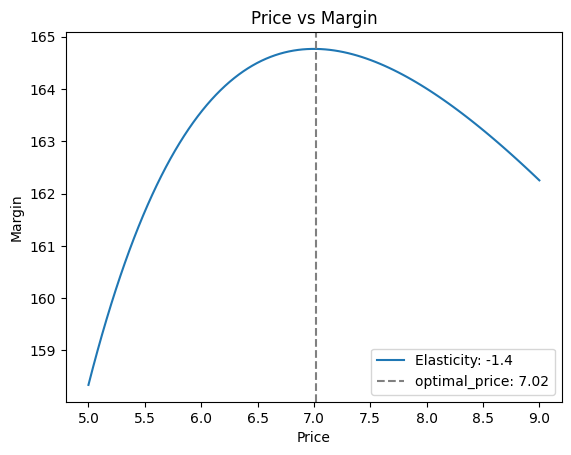

In [7]:
# Consider discounts between 10-50% off
discount = np.linspace(-0.1, -0.5, 100) # pct off
prices = (1 + discount) * baseline_price

def margin_fn(discount, baseline_price, elasticity, baseline_sales, cost=2):
    """Calculate revenues with different discount and elasticity scenarios"""
    chg = elasticity * np.log(1+discount)
    demand = baseline_sales * np.exp(chg)
    return demand * ((1 + discount) * baseline_price - cost) * -1 # for the minimization function

# Note we need to flip the sign for our plot
promo_margin = -margin_fn(discount, baseline_price, elasticity, baseline_sales, cost)

# Find maximum using our grid approximation
optimal_price = prices[np.argmax(promo_margin)]
optimal_price = np.round(optimal_price, 2)

# Plot the curve of Price and Revenue
plt.plot(prices, promo_margin, label=f'Elasticity: {elasticity}')
plt.axvline(optimal_price, linestyle='dashed', color='grey', label=f'optimal_price: {optimal_price}')
plt.title("Price vs Margin")
plt.xlabel("Price")
plt.ylabel("Margin")
plt.legend();

Note that we can try different values for the elasticity and it does matter. The sweet spot here seems to be around -1.3 to -1.6 to see this curve

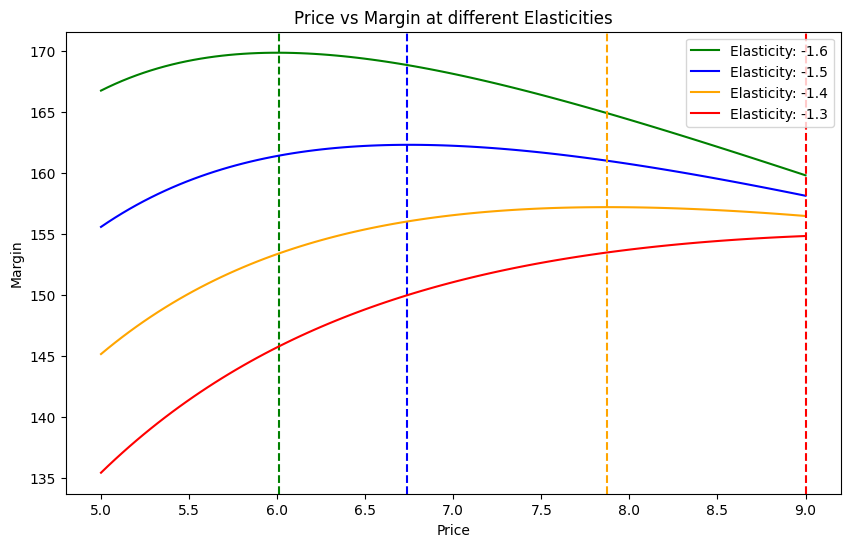

In [8]:
# Test different elasticities

plt.figure(figsize=(10,6))
colors = ['green', 'blue', 'orange', 'red']

for i,c in zip([-1.6, -1.5, -1.4, -1.3], colors):
    # Note we need to flip the sign for our plot
    _elas = np.round(i, 1)
    _promo_margin = -margin_fn(discount, baseline_price, _elas, baseline_sales, cost=2.25)
    plt.plot(prices, _promo_margin, label=f'Elasticity: {_elas}', color=c)
    _optimal_price = prices[np.argmax(_promo_margin)]
    _optimal_price = np.round(_optimal_price, 2)
    plt.axvline(_optimal_price, color=c, linestyle='--')

plt.xlabel("Price")
plt.ylabel("Margin")
plt.title("Price vs Margin at different Elasticities")
plt.legend()

We can also find the optimum using `scipy.optimize` instead of the grid approximation and get a more precise answer:

In [9]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(margin_fn, args=(baseline_price, elasticity, baseline_sales), bounds=[-0.5, -0.1], method='bounded')
optimal_discount = res.x
print("Optimal Discount: ", optimal_discount)
optimal_price = baseline_price * (1 + optimal_discount)
optimal_price = np.round(optimal_price, 2)
print("Optimal Price: ", optimal_price)

Optimal Discount:  -0.2999990215337986
Optimal Price:  7.0


So the ideal discount is about 30% to get to a \$7 price.

Next, we take this optimal price and find the optimal months that we should run this promotion:

In [10]:
# 2. Declare solver
# Create the mip solver with the SCIP backend.
promo_solver = pywraplp.Solver.CreateSolver("SCIP")

# ----- Decision Variables -----

# Which months to promote?
promo_months = [promo_solver.BoolVar(f"promo_month_{i}") for i in month_nums]
reg_months = [promo_solver.BoolVar(f"reg_month_{i}") for i in month_nums]

print("Number of variables: ", promo_solver.NumVariables())

# ----- Constraints ------
# No more than 4 months of promotions but at least 1 promotion per year
promo_solver.Add(sum(promo_months) <= 4)
promo_solver.Add(sum(promo_months) >= 1)

# Constraint that either we have a regular month or a promo month
for i in month_nums:
    promo_solver.Add(promo_months[i] + reg_months[i] == 1)

# ----- Objective Function -----
# Calculate unit sales

# Demand
promo_price = optimal_price # from previous step
discount_pct = (promo_price/baseline_price) - 1

monthly_sales = []
for i in month_nums:
    # Calculate either promo sales or reg sales depending on the decision variable
    _promo_sales = baseline_sales * seasonality[i] * np.exp(elasticity * np.log(1+discount_pct)) * promo_price * promo_months[i]
    _reg_sales = baseline_sales * seasonality[i] * baseline_price * reg_months[i]
    monthly_sales.append(sum([_promo_sales, _reg_sales]))

total_revenue = sum(monthly_sales)
promo_solver.Maximize(total_revenue)

status = promo_solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print("Solution: ")
    print("Objective value =", promo_solver.Objective().Value())
    for i in month_nums:
        if promo_months[i].solution_value() >0:
            print(f"promo_month_{i} =", promo_months[i].solution_value())

Number of variables:  24
Solution: 
Objective value = 2811.2133406463367
promo_month_4 = 1.0
promo_month_5 = 1.0
promo_month_6 = 1.0
promo_month_7 = 1.0


And we notice that the optimal months just happen to fall in those summer months. So in general what it's basically saying is for products that have this level of price elasticity, we should run this promotion during the busy season and avoid promoting when it's not busy. If elasticity was low (i.e. between -1 and 0), then we have the opposite recommendation and we should only promote when demand is low (if we have to run a promotion at all).

## What if elasticity is random?

The optimal promotional price then becomes the price that maximizes *expected* margin. That is, we need to estimate probabilities. We noted earlier that the decision function will change depending on the elasticity. If Elasticity is high, then the optimal decision will always be to lower price, but if Elasticity is low, then you'll never want to lower the price because it'll reduce your margins.

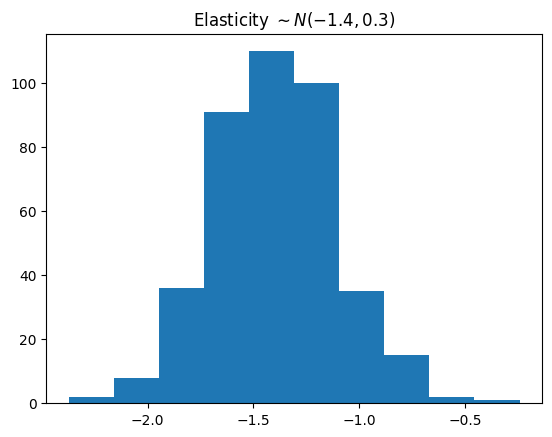

In [11]:
# let's simulate a distribution of elasticity coefficients using a random normal distribution
np.random.seed(42)
elasticities = np.random.normal(loc=-1.4, scale=0.3, size=400)
plt.hist(elasticities)
plt.title("Elasticity $\sim N(-1.4, 0.3)$");

We'll adjust the margin function to calculate the expected margin, which in this case will take the expected demand from 400 samples of this distribution of elasticity coefficients, and then re-run our optimization (minimization) problem:

In [12]:
def margin_fn2(discount, baseline_price, elasticities, baseline_sales, cost=2):
    """Calculate revenues with different discount and elasticity scenarios"""
    chg = elasticities * np.log(1+discount)
    # Expected demand
    demand = np.mean(baseline_sales * np.exp(chg))
    return demand * ((1 + discount) * baseline_price - cost) * -1 # for the minimization function

res = minimize_scalar(margin_fn2, args=(baseline_price, elasticities, baseline_sales), bounds=[-0.5, -0.1], method='bounded')
optimal_discount = res.x
print("Optimal Discount: ", optimal_discount)
optimal_price = baseline_price * (1 + optimal_discount)
optimal_price = np.round(optimal_price, 2)
print("Optimal Price: ", optimal_price)

Optimal Discount:  -0.3307329248088666
Optimal Price:  6.69


## What if there's cross elasticity?

In [13]:
def cross_margin_fn(discount, baseline_price, elasticity, baseline_sales, cross_elasticity, comp_discount, cost=2):
    """Calculate margin with different discount and elasticity scenarios with cross elasticity"""
    chg = (elasticity * np.log(1+discount)) + (cross_elasticity * np.log(1+comp_discount))
    demand = baseline_sales * np.exp(chg)
    return -demand * ((1 + discount) * baseline_price - cost)

In [14]:
cross_elasticity = 1.2
cross_elasticity2 = 1.75

comp_discount = -0.15
comp_discount2 = -0.3

xrev = -cross_margin_fn(discount, baseline_price, elasticity, baseline_sales, cross_elasticity, comp_discount, cost)
xrev2 = -cross_margin_fn(discount, baseline_price, elasticity, baseline_sales, cross_elasticity, comp_discount2, cost)
xrev3 = -cross_margin_fn(discount, baseline_price, elasticity, baseline_sales, cross_elasticity2, comp_discount, cost)
xrev4 = -cross_margin_fn(discount, baseline_price, elasticity, baseline_sales, cross_elasticity2, comp_discount2, cost)

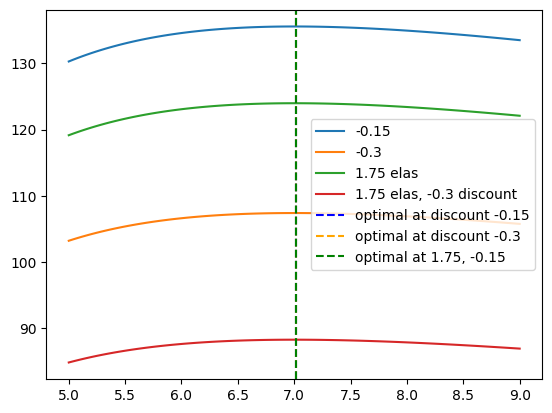

In [15]:
plt.plot(prices, xrev, label=f'{comp_discount}')
plt.plot(prices, xrev2, label=f'{comp_discount2}')
plt.plot(prices, xrev3, label=f'{cross_elasticity2} elas')
plt.plot(prices, xrev4, label=f'{cross_elasticity2} elas, {comp_discount2} discount')

plt.axvline(prices[np.argmax(xrev)], linestyle='dashed', color='blue', label=f'optimal at discount {comp_discount}')
plt.axvline(prices[np.argmax(xrev2)], linestyle='dashed', c='orange', label=f'optimal at discount {comp_discount2}')
plt.axvline(prices[np.argmax(xrev3)], linestyle='dashed', c='green', label=f'optimal at {cross_elasticity2}, {comp_discount}')
plt.legend()

It doesn't seem to change the optimal price offering at all in this model - changing the comp discount just shifts the entire curve up/down and the cross elasticity just flattens/smooths the curve.

## What if difference in price matters?

Let's say that we add an interaction term that's the difference in price rather than the cross elasticity, how would that affect our revenue curve?

So then every time our price changes, the difference in price should change, as well.

In second thought, this may be a bad idea

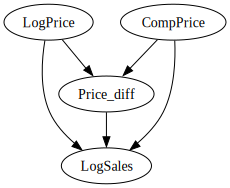

In [16]:
import graphviz as gr

g = gr.Digraph('dag')
g.edge('LogPrice', 'LogSales')
g.edge('Price_diff', 'LogSales')
g.edge('LogPrice', 'Price_diff')
g.edge('CompPrice', 'Price_diff')
g.edge('CompPrice', 'LogSales')
g

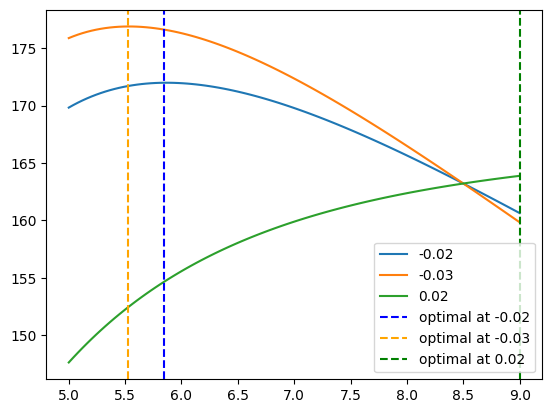

In [17]:
def price_diff_margin_fn(discount, baseline_price, elasticity, baseline_sales, diff_elasticity, comp_price, cost=2):
    """Calculate margin with different discount and elasticity scenarios"""
    baseline_price_diff = baseline_price - comp_price
    price_diff_after_discount = (baseline_price * (1+discount)) - comp_price
    # Pct change in the price difference
    diff_change_pct = (price_diff_after_discount/baseline_price_diff) - 1 

    chg1 = (elasticity * np.log(1+discount)) 
    chg2 = (diff_elasticity * price_diff_after_discount) # Watch out here, we can't take a log of a negative number
    demand = baseline_sales * np.exp(chg1 + chg2)
    return -demand * ((1 + discount) * baseline_price - cost)

diff_elasticity = -0.02
scenario_2 = -0.03
scenario_3 = 0.02

comp_price = 8.5

xrev = -price_diff_margin_fn(discount, baseline_price, elasticity, baseline_sales, diff_elasticity, comp_price, cost)
xrev2 = -price_diff_margin_fn(discount, baseline_price, elasticity, baseline_sales, scenario_2, comp_price, cost)
xrev3 = -price_diff_margin_fn(discount, baseline_price, elasticity, baseline_sales, scenario_3, comp_price, cost)

plt.plot(prices, xrev, label='-0.02')
plt.plot(prices, xrev2, label=f'{scenario_2}')
plt.plot(prices, xrev3, label=f'{scenario_3}')
plt.axvline(prices[np.argmax(xrev)], linestyle='dashed', color='blue', label='optimal at -0.02')
plt.axvline(prices[np.argmax(xrev2)], linestyle='dashed', c='orange', label=f'optimal at {scenario_2}')
plt.axvline(prices[np.argmax(xrev3)], linestyle='dashed', c='green', label=f'optimal at {scenario_3}')

plt.legend()

Under this model, we see that where the price diff elasticity is more negative, then decreasing the price becomes more optimal. But where the price diff elasticity is positive, then lowering the price no longer gets you as great of a benefit. 

If diff elasticity is very negative though, then this could lead us to a situation where we'd want to lower the price a lot.

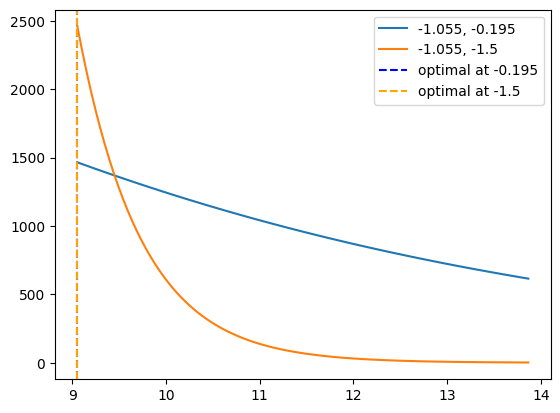

In [18]:
low_elasticity_scenario = -1.055

# price diff coefficients
scenario_1 = -0.195
scenario_2 = -1.5

baseline_price = 11.46
# Consider discounts between 10-50% off
discount = np.linspace(-0.21, 0.21, 100)
prices = (1 + discount) * baseline_price
comp_price = 9.45
baseline_sales = 150

xrev = -price_diff_margin_fn(discount, baseline_price, low_elasticity_scenario, baseline_sales, scenario_1, comp_price, cost)
xrev2 = -price_diff_margin_fn(discount, baseline_price, low_elasticity_scenario, baseline_sales, scenario_2, comp_price, cost)

plt.plot(prices, xrev, label=f'{low_elasticity_scenario}, {scenario_1}')
plt.plot(prices, xrev2, label=f'{low_elasticity_scenario}, {scenario_2}')
plt.axvline(prices[np.argmax(xrev)], linestyle='dashed', color='blue', label=f'optimal at {scenario_1}')
plt.axvline(prices[np.argmax(xrev2)], linestyle='dashed', c='orange', label=f'optimal at {scenario_2}')
plt.legend()

In [19]:
res = minimize_scalar(price_diff_revenue_fn, args=(baseline_price, low_elasticity_scenario, baseline_sales, scenario_1, comp_price), bounds=[-0.3, 0.3], method='bounded')
# Optimal Price?
baseline_price * (1 + res.x)

NameError: name 'price_diff_revenue_fn' is not defined